# Integrasi Model K-Nearest Neighbors (KNN) dengan Hyperparameter Tunning Optuna Untuk Mendeteksi Penyakit Liver Sejak Dini - Dadan Ahmad Dani

### Library

In [86]:
#Install Optuna
!pip install --quiet optuna

In [87]:
#Pemrosesan Data
import numpy as np
import pandas as pd
from scipy import stats
#Visualisasi
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
# Scale
from sklearn.preprocessing import LabelEncoder,StandardScaler
# Model KNN
from sklearn.neighbors import KNeighborsClassifier
# Hyperparameter Tuning
import optuna
#Model Selection
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold
#Resample Data
from imblearn.over_sampling import SMOTE
#Matriks Evaluasi
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
#Warning
import warnings
warnings.filterwarnings('ignore')

### Informasi Dataset

In [88]:
#load dataset csv
liver_df = pd.read_csv('Indian Liver Patient Dataset (ILPD).csv')
#tampilkan datasetnya
liver_df.head()

,Age,Gender,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G,Class
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


In [90]:
#Jumlah rows dan column
print(f'Dataset ini memiliki {liver_df.shape[0]} rows and {liver_df.shape[1]} columns\n')
#cek data types untuk masing-masing kolom
liver_df.info()

Dataset ini memiliki 583 rows and 11 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Age      583 non-null    int64  
 1   Gender   583 non-null    object 
 2   TB       583 non-null    float64
 3   DB       583 non-null    float64
 4   Alkphos  583 non-null    int64  
 5   Sgpt     583 non-null    int64  
 6   Sgot     583 non-null    int64  
 7   TP       583 non-null    float64
 8   ALB      583 non-null    float64
 9   A/G      579 non-null    float64
 10  Class    583 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB


In [91]:
#kolom numerik
feature_numeric = ['Age','TB','DB','Alkphos','Sgpt','Sgot','TP','ALB','A/G']
#kolom klasifikasi Liver dan Non Liver (1: Liver dan 2:Non-Liver)
liver_df['Class'].replace({1:"Liver" , 2:"Non-Liver"},inplace = True)
target_label=['Class']
#data untuk pasien Liver
df_liv=liver_df[(liver_df['Class']=="Liver")]

### Missing Value

In [92]:
#cek jumlah missing value tiap kolom
print('Jumlah Missing Value Tiap Kolom')
liver_df.isnull().sum()

Jumlah Missing Value Tiap Kolom


Age        0
Gender     0
TB         0
DB         0
Alkphos    0
Sgpt       0
Sgot       0
TP         0
ALB        0
A/G        4
Class      0
dtype: int64

In [94]:
#isi 4 kolom A/G yg kosong dengan menggunakan nilai rata-rata (mean) dari nilai A/G
liver_df["A/G"] = liver_df["A/G"].fillna(liver_df["A/G"].mean())
#cek kembali hasilnya
print('Setelah Penanganan')
liver_df.isnull().sum()

Setelah Penanganan


Age        0
Gender     0
TB         0
DB         0
Alkphos    0
Sgpt       0
Sgot       0
TP         0
ALB        0
A/G        0
Class      0
dtype: int64

### Statistik Deskriptif Variabel Fitur Numerik

In [95]:
#deskripsi fitur numerik
liver_df[feature_numeric].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,583.0,44.746141,16.189833,4.0,33.0,45.000000,58.0,90.0
TB,583.0,3.298799,6.209522,0.4,0.8,1.000000,2.6,75.0
DB,583.0,1.486106,2.808498,0.1,0.2,0.300000,1.3,19.7
Alkphos,583.0,290.576329,242.937989,63.0,175.5,208.000000,298.0,2110.0
Sgpt,583.0,80.713551,182.620356,10.0,23.0,35.000000,60.5,2000.0
Sgot,583.0,109.910806,288.918529,10.0,25.0,42.000000,87.0,4929.0
TP,583.0,6.483190,1.085451,2.7,5.8,6.600000,7.2,9.6
ALB,583.0,3.141852,0.795519,0.9,2.6,3.100000,3.8,5.5
A/G,583.0,0.947064,0.318492,0.3,0.7,0.947064,1.1,2.8


### Deteksi Imbalance pada Variabel Target

In [96]:
liver_df['Class'].value_counts()

Liver        416
Non-Liver    167
Name: Class, dtype: int64

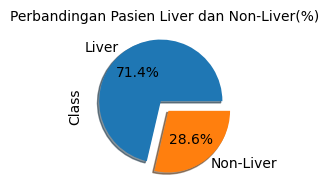

In [97]:
#Perbandingan Jumlah Pasien Liver dan Non Liver (%)
def plot_pie_liver_patient():
    labels1 = 'Liver','Non-Liver'
    liver_df['Class'].value_counts().plot.pie(explode=[0.1,0.1],labels=labels1, autopct='%1.1f%%',shadow=True,figsize=(2,2));
    plt.title("Perbandingan Pasien Liver dan Non-Liver(%)",fontsize=10)
plot_pie_liver_patient()

### Exploratory Data Analysis (EDA)- Univariate Analysis

In [98]:
liver_df['Gender'].value_counts()

Male      441
Female    142
Name: Gender, dtype: int64

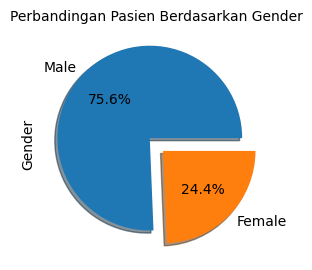

In [99]:
def plot_pie_gender():
    labels_gend = 'Male','Female'
    liver_df['Gender'].value_counts().plot.pie(explode=[0.1,0.1],labels=labels_gend, autopct='%1.1f%%',shadow=True,figsize=(3,3));
    plt.title("Perbandingan Pasien Berdasarkan Gender",fontsize=10)
plot_pie_gender()

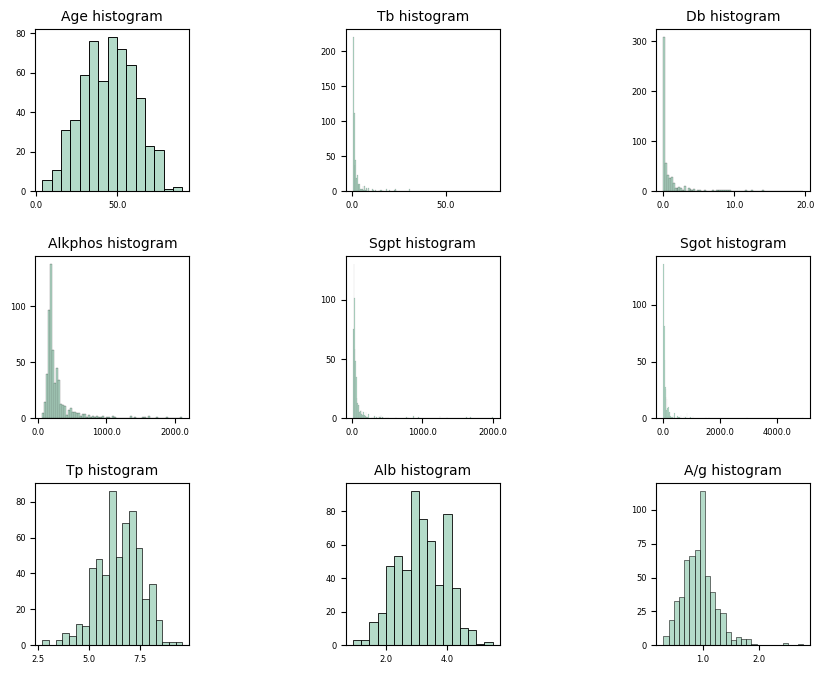

In [100]:
def plot_histogram(X_num):
      plot_number = 1
      plt.figure(figsize=(12,8))
      plt.subplots_adjust(hspace=0.4, wspace=0.01)
      for col in X_num.columns:
          plt.subplot(3, 6, plot_number)
          sns.histplot(X_num[col], color="#9bd0b7")
          plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
          plt.title(f'{col.capitalize()} histogram', fontsize=10)
          plt.xlabel('')
          plt.xticks(fontsize=6)
          plt.ylabel('')
          plt.yticks(fontsize=6)
          plot_number = plot_number+2
      plt.show()
plot_histogram(liver_df[feature_numeric])

### Exploratory Data Analysis (EDA)-Multivariate Analysis

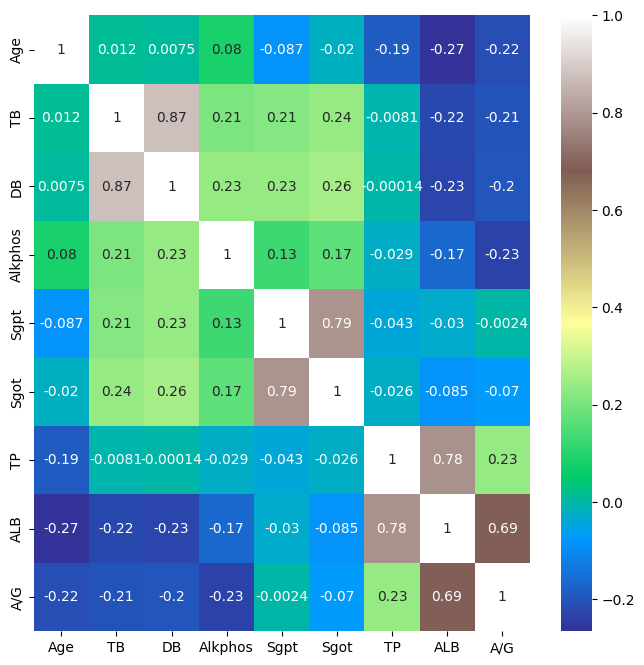

In [101]:
#Korelasi Variabel Numerik
def plot_corr():
	plt.figure(figsize=(8,8))
	sns.heatmap(liver_df[feature_numeric].corr(),annot=True,cmap = 'terrain')
plot_corr()


### Outlier

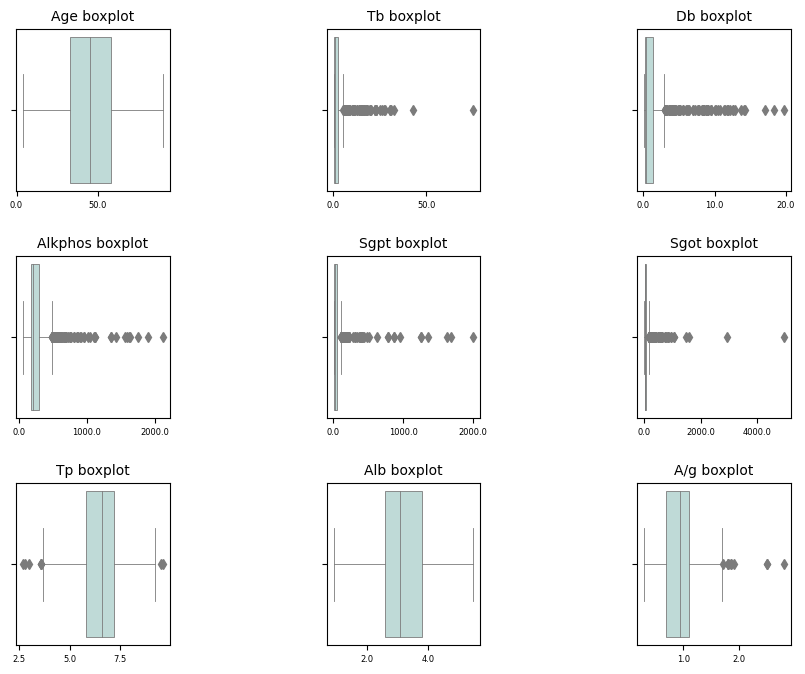

In [102]:
#outlier boxplot
def plot_boxplot(X_num):
      plot_number = 1
      plt.figure(figsize=(12,8))
      plt.subplots_adjust(hspace=0.4, wspace=0.01)
      for col in X_num.columns:
          plt.subplot(3, 6, plot_number)
          sns.boxplot(x=X_num[col], color='#badfda', width=0.9, linewidth=0.6)
          plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
          plt.title(f'{col.capitalize()} boxplot', fontsize=10)
          plt.xlabel('')
          plt.xticks(fontsize=6)
          plt.ylabel('')
          plt.yticks(fontsize=6)
          plot_number = plot_number+2
      plt.show()
plot_boxplot(liver_df[feature_numeric])

In [103]:
#hitung jumlah outlier masing masing kolom dengan menggunakan metode IQR dan tampilkan dalam tabel
def count_Outliers(X_num):
    indices = [x for x in X_num.index]
    out_indexlist = []
    outlier_tbl=[]
    for col in feature_numeric:
        q1 = np.percentile(X_num[col], 25)
        q3 = np.percentile(X_num[col], 75)
        iqr = q3 - q1
        lower = q1 - (iqr*1.5)
        upper = q3 + (iqr*1.5)
        outliers_index = X_num[col][(X_num[col] < lower) | (X_num[col] > upper)].index.tolist()
        outliers = X_num[col][(X_num[col] < lower) | (X_num[col] > upper)].values
        out_indexlist.extend(outliers_index)
        outlier_tbl.append({
            'Fitur': col,
            'Jml Outlier': len(outliers),
        })
    print('\nTotal outliers: ', len(out_indexlist))
    out_df = pd.DataFrame(outlier_tbl,columns=['Fitur','Jml Outlier'])
    return out_df

count_Outliers(liver_df[feature_numeric])


Total outliers:  391


,Fitur,Jml Outlier
0,Age,0
1,TB,84
2,DB,81
3,Alkphos,69
4,Sgpt,73
5,Sgot,66
6,TP,8
7,ALB,0
8,A/G,10


In [104]:
#handle outlier: jika outlier diatas upper diganti nilainya dengan nilai upper dan outlier dibawah lower diganti nilainya dengan lower
for c_kol in feature_numeric:
    q1 = np.percentile(liver_df[c_kol], 25)
    q3 = np.percentile(liver_df[c_kol], 75)
    iqr = q3 - q1
    lower = q1 - (iqr*1.5)
    upper = q3 + (iqr*1.5)
    liver_df[c_kol]= liver_df[c_kol].apply(lambda x: lower if x<lower else x)
    liver_df[c_kol] = liver_df[c_kol].apply(lambda x: upper if x>upper else x)

#tampilkan kembali jumlah outlier
count_Outliers(liver_df[feature_numeric])


Total outliers:  0


,Fitur,Jml Outlier
0,Age,0
1,TB,0
2,DB,0
3,Alkphos,0
4,Sgpt,0
5,Sgot,0
6,TP,0
7,ALB,0
8,A/G,0


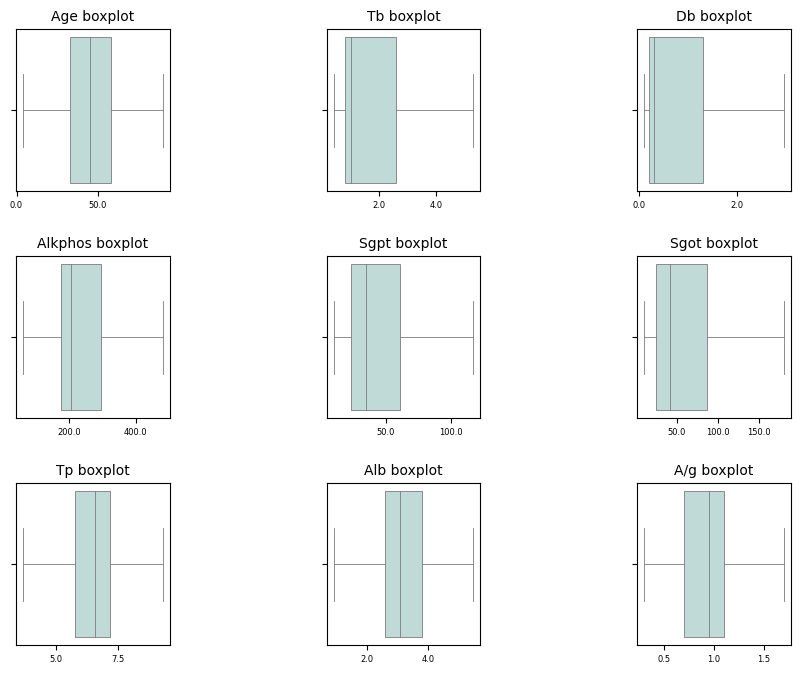

In [105]:
plot_boxplot(liver_df[feature_numeric])

### Label Encoding

In [106]:
#Label Encoding

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()
# Fit and transform the categorical labels to numerical values
liver_df['Gender'] = label_encoder.fit_transform(liver_df['Gender'])
print('Class->Liver:1 dan Non-Liver:2')
liver_df['Class'].replace({"Liver":1 , "Non-Liver":2},inplace = True)
liver_df

Class->Liver:1 dan Non-Liver:2


,Age,Gender,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G,Class
0,65,0,0.7,0.10,187.00,16.0,18.0,6.8,3.3,0.90,1
1,62,1,5.3,2.95,481.75,64.0,100.0,7.5,3.2,0.74,1
2,62,1,5.3,2.95,481.75,60.0,68.0,7.0,3.3,0.89,1
3,58,1,1.0,0.40,182.00,14.0,20.0,6.8,3.4,1.00,1
4,72,1,3.9,2.00,195.00,27.0,59.0,7.3,2.4,0.40,1
...,...,...,...,...,...,...,...,...,...,...,...
578,60,1,0.5,0.10,481.75,20.0,34.0,5.9,1.6,0.37,2
579,40,1,0.6,0.10,98.00,35.0,31.0,6.0,3.2,1.10,1
580,52,1,0.8,0.20,245.00,48.0,49.0,6.4,3.2,1.00,1
581,31,1,1.3,0.50,184.00,29.0,32.0,6.8,3.4,1.00,1


### Split data training dan testing

In [107]:
#split data ke dalam data latih (80%) dan data Uji (20%)
X=liver_df.drop(['Class'],axis = 1)
y=liver_df['Class']
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=123,stratify= y)
print(f'x_train: {x_train.shape}')
print(f'x_test: {x_test.shape}')

x_train: (466, 10)
x_test: (117, 10)


In [108]:
y_train.value_counts()

1    333
2    133
Name: Class, dtype: int64

In [110]:
y_test.value_counts()

1    83
2    34
Name: Class, dtype: int64

### Normalisasi Data

In [111]:
#StandardScaler
x_train_scaler = StandardScaler().fit_transform(x_train)
x_test_scaler = StandardScaler().fit_transform(x_test)
print(f'x_train_scaler: {x_train_scaler.shape}')
print(f'x_test_scaler: {x_test_scaler.shape}')

x_train_scaler: (466, 10)
x_test_scaler: (117, 10)


### Resample Data

In [112]:
#SMOTE
smote_resample = SMOTE(sampling_strategy='auto')
x_train_resampled, y_train_resampled = smote_resample.fit_resample(x_train_scaler, y_train)
print(f'x_train_resampled: {x_train_resampled.shape}')

x_train_resampled: (666, 10)


In [113]:
y_train_resampled.value_counts()

2    333
1    333
Name: Class, dtype: int64

### Modeling

In [114]:
# model 1
knn_model_scaler = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='minkowski')
knn_model_scaler.fit(x_train_scaler, y_train)

KNeighborsClassifier()

In [115]:
#Skor Training Model
score_knn_model_scaler=cross_val_score(knn_model_scaler, x_train_scaler, y_train, scoring='accuracy', cv=5)
score_knn_model_scaler

array([0.59574468, 0.64516129, 0.68817204, 0.66666667, 0.78494624])

In [117]:
#counfussion metric
def plot_confusion_matrixs(actual,prediction,judul):
    cm = confusion_matrix(actual,prediction)
    cm_df = pd.DataFrame(cm,index = ['Liver','Non-Liver'],columns = ['Liver','Non-Liver'])
    #Plotting the confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True)
    plt.title(judul)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

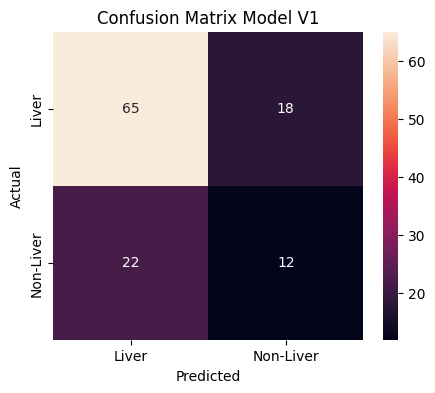

Classification Report Model V1:
              precision    recall  f1-score   support

           1       0.75      0.78      0.76        83
           2       0.40      0.35      0.38        34

    accuracy                           0.66       117
   macro avg       0.57      0.57      0.57       117
weighted avg       0.65      0.66      0.65       117



In [118]:
# CM Model 1
y_pred_scaler = knn_model_scaler.predict(x_test_scaler)
plot_confusion_matrixs(y_test, y_pred_scaler,'Confusion Matrix Model V1')
class_report_scaler = classification_report(y_test, y_pred_scaler)
print("Classification Report Model V1:")
print(class_report_scaler)

### Evaluasi Model dengan Data Latih SMOTE

In [119]:
# model 2
knn_model_smote = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='minkowski')
knn_model_smote.fit(x_train_resampled, y_train_resampled)

KNeighborsClassifier()

In [120]:
score_knn_model_smote=cross_val_score(knn_model_smote, x_train_resampled, y_train_resampled, scoring='accuracy', cv=5)
score_knn_model_smote

array([0.67910448, 0.70676692, 0.72180451, 0.76691729, 0.77443609])

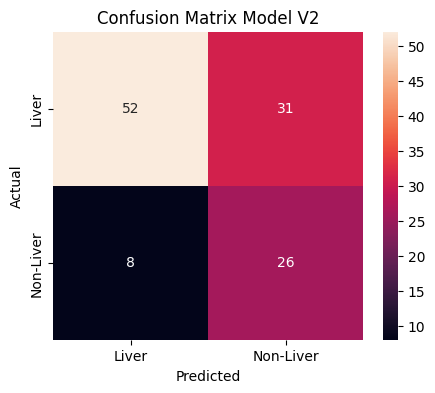

Classification Report Model V2:
              precision    recall  f1-score   support

           1       0.87      0.63      0.73        83
           2       0.46      0.76      0.57        34

    accuracy                           0.67       117
   macro avg       0.66      0.70      0.65       117
weighted avg       0.75      0.67      0.68       117



In [121]:
# CM Model 2
y_pred_smote = knn_model_smote.predict(x_test_scaler)
plot_confusion_matrixs(y_test, y_pred_smote,'Confusion Matrix Model V2')
class_report_smote = classification_report(y_test, y_pred_smote)
print("Classification Report Model V2:")
print(class_report_smote)

### Evaluasi Model dengan tunning Hyperparameter Optuna

In [122]:
#model 3
def objective(trial):
    #knn parameter
    n_neighbors = trial.suggest_int("n_neighbors", 1,10)
    weights = trial.suggest_categorical("weights", ['uniform', 'distance'])
    metric = trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski'])

    #knn model
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric)

    # Latih model dengan data latih
    knn_model.fit(x_train_resampled, y_train_resampled)

    # Prediksi label pada data uji
    y_pred = knn_model.predict(x_test_scaler)

    # Hitung akurasi prediksi
    accuracy = accuracy_score(y_test, y_pred)

    # Kembalikan akurasi sebagai skor optimasi
    return accuracy

In [123]:
#run optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=300)


[I 2023-07-24 07:21:05,472] A new study created in memory with name: no-name-a9ad2a73-b46e-4058-b533-c4105b521786
[I 2023-07-24 07:21:05,485] Trial 0 finished with value: 0.6410256410256411 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 0 with value: 0.6410256410256411.
[I 2023-07-24 07:21:05,500] Trial 1 finished with value: 0.7008547008547008 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 1 with value: 0.7008547008547008.
[I 2023-07-24 07:21:05,513] Trial 2 finished with value: 0.6752136752136753 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 1 with value: 0.7008547008547008.
[I 2023-07-24 07:21:05,525] Trial 3 finished with value: 0.6752136752136753 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 1 with value: 0.7008547008547008.
[I 2023-07-24 07:21:05,541] Trial 4 finished with value: 0.6923

In [124]:
optuna.visualization.plot_optimization_history(study)

In [125]:
optuna.visualization.plot_param_importances(study)

In [126]:
#get best params
best_params = study.best_params
best_params

{'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan'}

In [127]:
#create models best params
def create_model_best_params(best_params):
    best_n_neighbors =best_params['n_neighbors']
    best_weights =best_params['weights']
    best_metric =best_params['metric']
    knn_optuna=KNeighborsClassifier(n_neighbors=best_n_neighbors,weights=best_weights,metric=best_metric)
    return knn_optuna

knn_model_optuna=create_model_best_params(best_params)
knn_model_optuna.fit(x_train_resampled, y_train_resampled)

KNeighborsClassifier(metric='manhattan', weights='distance')

In [128]:
score_knn_model_optuna=cross_val_score(knn_model_optuna, x_train_resampled, y_train_resampled, scoring='accuracy', cv=5)
score_knn_model_optuna

array([0.7238806 , 0.78947368, 0.77443609, 0.77443609, 0.81203008])

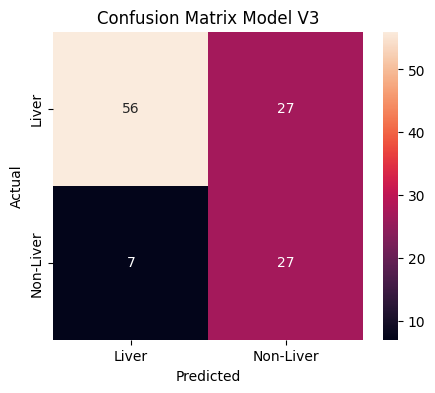

Classification Report Model V2:
              precision    recall  f1-score   support

           1       0.89      0.67      0.77        83
           2       0.50      0.79      0.61        34

    accuracy                           0.71       117
   macro avg       0.69      0.73      0.69       117
weighted avg       0.78      0.71      0.72       117



In [129]:
# CM Model 3
y_pred_optuna = knn_model_optuna.predict(x_test_scaler)
plot_confusion_matrixs(y_test, y_pred_optuna,'Confusion Matrix Model V3')
class_report_optuna = classification_report(y_test, y_pred_optuna)
print("Classification Report Model V2:")
print(class_report_optuna)

### Matriks Evaluasi Model

In [138]:
def calculate_tp_tn_fp_fn(confusion_matrix):

    # [[TP, FP],
    #  [FN, TN]]

    # Mengekstrak nilai TN, FP, FN, dan TP dari confusion matrix
    TP = confusion_matrix[0][0]
    FP = confusion_matrix[0][1]
    FN = confusion_matrix[1][0]
    TN = confusion_matrix[1][1]
    return TP, TN, FP, FN

def create_confusion_matrix_table(confusion_matrices):
    data = {
        'Confusion Matrix': [],
        'True Positive (TP)': [],
        'False Positive (FP)': [],
        'True Negative (TN)': [],
        'False Negative (FN)': []
    }

    for i, confusion_matrix in enumerate(confusion_matrices, start=1):
        TP, TN, FP, FN = calculate_tp_tn_fp_fn(confusion_matrix)
        data['Confusion Matrix'].append(f'Model {i}')
        data['True Positive (TP)'].append(TP)
        data['False Positive (FP)'].append(FP)
        data['True Negative (TN)'].append(TN)
        data['False Negative (FN)'].append(FN)

    df = pd.DataFrame(data)
    return df


confusion_matrices_all = [
	confusion_matrix(y_test, y_pred_scaler),
	confusion_matrix(y_test, y_pred_smote),
	confusion_matrix(y_test, y_pred_optuna)
]

confusion_matrix_table = create_confusion_matrix_table(confusion_matrices_all)
confusion_matrix_table

,Confusion Matrix,True Positive (TP),False Positive (FP),True Negative (TN),False Negative (FN)
0,Model 1,65,18,12,22
1,Model 2,52,31,26,8
2,Model 3,56,27,27,7


In [139]:
def calculate_metrics(TP, TN, FP, FN):
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)
    return accuracy, precision, recall, f1_score

# Menghitung akurasi, presisi, recall, dan F1-Score
confusion_matrix_table['Accuracy'], confusion_matrix_table['Precision'], confusion_matrix_table['Recall'], confusion_matrix_table['F1-Score'] = zip(*confusion_matrix_table.apply(
    lambda row: calculate_metrics(row['True Positive (TP)'], row['True Negative (TN)'], row['False Positive (FP)'], row['False Negative (FN)']), axis=1
))

confusion_matrix_table

,Confusion Matrix,True Positive (TP),False Positive (FP),True Negative (TN),False Negative (FN),Accuracy,Precision,Recall,F1-Score
0,Model 1,65,18,12,22,0.658120,0.783133,0.747126,0.764706
1,Model 2,52,31,26,8,0.666667,0.626506,0.866667,0.727273
2,Model 3,56,27,27,7,0.709402,0.674699,0.888889,0.767123


In [141]:
#Berdasarkan Data Latih
print(f'Akurasi Skor Model 1: {round(score_knn_model_scaler.mean(),2)}')
print(f'Akurasi Skor Model 2: {round(score_knn_model_smote.mean(),2)}')
print(f'Akurasi Skor Model 3: {round(score_knn_model_optuna.mean(),2)}')

Akurasi Skor Model 1: 0.68
Akurasi Skor Model 2: 0.73
Akurasi Skor Model 3: 0.77
